## Classification of Digits in Sudoku Grid - Task - 1

The project objective is to train a deep learning model to read the Sudoku puzzle to know which digits there are and where are their placed within the Sudoku grid.


#### *Importing Required libraries*

In [9]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import optim
from torch import nn
import numpy as np

#### 2. *Data Visualisation*


1. **Understanding training data and labels.:**
   - Train data consists of list of incomplete sudoku puzzle where blank space indicates 0 value. and labels consists of list of 41,3 matrix which is ideally, values of the image
   - for Example : [0., 2., 3.] = 0,2 is position of image 0th row and 2nd column and 3 is the value associated with that position.

In [10]:
training_images = np.load("/kaggle/input/sudoku-task1/training_images.npy", mmap_mode='r')
training_labels = np.load("/kaggle/input/sudoku-task1/known_values_labels.npy", mmap_mode='r')

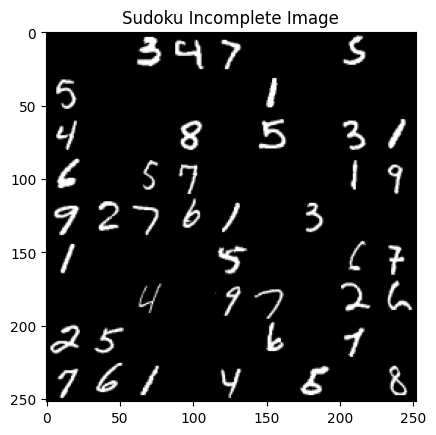

In [11]:
plt.imshow(training_images[0], cmap='gray')
plt.title('Sudoku Incomplete Image')
plt.show()


In [12]:
training_labels[0]

memmap([[0., 2., 3.],
        [0., 3., 4.],
        [0., 4., 7.],
        [0., 7., 5.],
        [1., 0., 5.],
        [1., 5., 1.],
        [2., 0., 4.],
        [2., 3., 8.],
        [2., 5., 5.],
        [2., 7., 3.],
        [2., 8., 1.],
        [3., 0., 6.],
        [3., 2., 5.],
        [3., 3., 7.],
        [3., 7., 1.],
        [3., 8., 9.],
        [4., 0., 9.],
        [4., 1., 2.],
        [4., 2., 7.],
        [4., 3., 6.],
        [4., 4., 1.],
        [4., 6., 3.],
        [5., 0., 1.],
        [5., 4., 5.],
        [5., 7., 6.],
        [5., 8., 7.],
        [6., 2., 4.],
        [6., 4., 9.],
        [6., 5., 7.],
        [6., 7., 2.],
        [6., 8., 6.],
        [7., 0., 2.],
        [7., 1., 5.],
        [7., 5., 6.],
        [7., 7., 7.],
        [8., 0., 7.],
        [8., 1., 6.],
        [8., 2., 1.],
        [8., 4., 4.],
        [8., 6., 5.],
        [8., 8., 8.]])

#### *Define Dataloaders*

1. **Data Transformation**:
   - A transformation pipeline (`transforms.Compose`) is defined to normalize the data. The transformation includes converting the data to tensors and normalizing the pixel values to the range [-1, 1] using the `transforms.Normalize` function.

2. **Data Loading**:
   - The MNIST dataset is downloaded and loaded using the `datasets.MNIST` class. 
   - For the training set (`train=True`), transformations are applied as defined in the `transform` pipeline.
   - For the evaluation set (`train=False`), the same transformations are applied.
   
3. **Data Loaders**:
   - Training and evaluation data are loaded into PyTorch `DataLoader` objects.
   - The data is batched into batches of size 64 (`batch_size=64`).
   - The `shuffle` parameter is set to `True` to shuffle the data during training and evaluation.

In [13]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])

train_data = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=True, transform=transform)
eval_data = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
eval_loader = torch.utils.data.DataLoader(eval_data, batch_size=64, shuffle=True)

### Defining The Neural Network

1. **Layer Configuration**:
  - `input_size`: Number of input features, which is 784 in this case, corresponding to the flattened MNIST images (28x28 pixels).
  - `hidden_sizes`: A list containing the number of units in each hidden layer. It is set to `[128, 64, 32]`, indicating three hidden layers with 128, 64, and 32 units, respectively.
  - `output_size`: Number of output units, which is 10, representing the number of classes in the MNIST dataset (digits 0 to 9).

2. **Model Architecture**:
  - The model is defined as a `Sequential` neural network using `nn.Sequential`.
  - It consists of four fully connected layers (`nn.Linear`) followed by ReLU activation functions (`nn.ReLU`) for each hidden layer.
  - The output layer uses `nn.LogSoftmax(dim=1)` activation, suitable for classification tasks, applied along the second dimension.
  
3.  **Loss Function and Optimizer**:
  - Cross-entropy loss (`nn.CrossEntropyLoss()`) is used as the loss function.
  - Adam optimizer (`optim.Adam()`) is employed with a learning rate of 0.01.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 784
hidden_sizes = [128, 64, 32]
output_size = 10 

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2], output_size),
                      nn.LogSoftmax(dim=1))
model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)
epochs = 25

#### *Training Loop*

1. **Training Loop**:
    - The training loop runs for `epochs` iterations.
    - The model is set to training mode (`model.train()`).
    - For each batch in the training data loader (`trainloader`), the optimizer parameters are zeroed, forward pass is computed, loss is calculated, gradients are computed and updated.
    - Additionally, the model is set to evaluation mode (`model.eval()`), and the validation loss and accuracy are computed using the validation data loader (`eval_loader`).
    - At the end of each epoch, the current epoch number, training loss and accuracy, and validation loss and accuracy are printed and same is plotted.

In [16]:
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

for e in range(epochs):
    training_loss = 0
    correct_predictions_train = 0
    total_train = 0
    
    # Training mode
    model.train()
    
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(output.data, 1)
        total_train += labels.size(0)
        correct_predictions_train += (predicted == labels).sum().item()
        
        training_loss += loss.item()
    
    # Evaluation mode
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        correct_predictions_valid = 0
        total_valid = 0
        for images, labels in eval_loader:
            images = images.view(images.shape[0], -1).to(device)
            labels = labels.to(device)
            
            output = model(images)
            loss = criterion(output, labels)
            valid_loss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            total_valid += labels.size(0)
            correct_predictions_valid += (predicted == labels).sum().item()
        
    train_loss = training_loss/len(trainloader)
    valid_loss = valid_loss/len(eval_loader)
    
    train_acc = correct_predictions_train / total_train
    valid_acc = correct_predictions_valid / total_valid
    
    train_losses.append(round(train_loss, 3))
    valid_losses.append(round(valid_loss, 3))
    train_accuracy.append(round(train_acc, 3))
    valid_accuracy.append(round(valid_acc, 3))
        
    print(f"Epoch {e+1}/{epochs} - Training Loss: {train_loss:.2f} - Training Accuracy: {train_acc:.2f} - Validation Loss: {valid_loss:.2f}  - Validation Accuracy: {valid_acc:.2f}")


Epoch 1/25 - Training Loss: 0.42 - Training Accuracy: 0.87 - Validation Loss: 0.27  - Validation Accuracy: 0.92
Epoch 2/25 - Training Loss: 0.25 - Training Accuracy: 0.93 - Validation Loss: 0.25  - Validation Accuracy: 0.93
Epoch 3/25 - Training Loss: 0.23 - Training Accuracy: 0.94 - Validation Loss: 0.33  - Validation Accuracy: 0.91
Epoch 4/25 - Training Loss: 0.22 - Training Accuracy: 0.94 - Validation Loss: 0.28  - Validation Accuracy: 0.92
Epoch 5/25 - Training Loss: 0.21 - Training Accuracy: 0.94 - Validation Loss: 0.22  - Validation Accuracy: 0.94
Epoch 6/25 - Training Loss: 0.20 - Training Accuracy: 0.95 - Validation Loss: 0.18  - Validation Accuracy: 0.95
Epoch 7/25 - Training Loss: 0.20 - Training Accuracy: 0.95 - Validation Loss: 0.20  - Validation Accuracy: 0.95
Epoch 8/25 - Training Loss: 0.19 - Training Accuracy: 0.95 - Validation Loss: 0.25  - Validation Accuracy: 0.94
Epoch 9/25 - Training Loss: 0.19 - Training Accuracy: 0.95 - Validation Loss: 0.23  - Validation Accurac

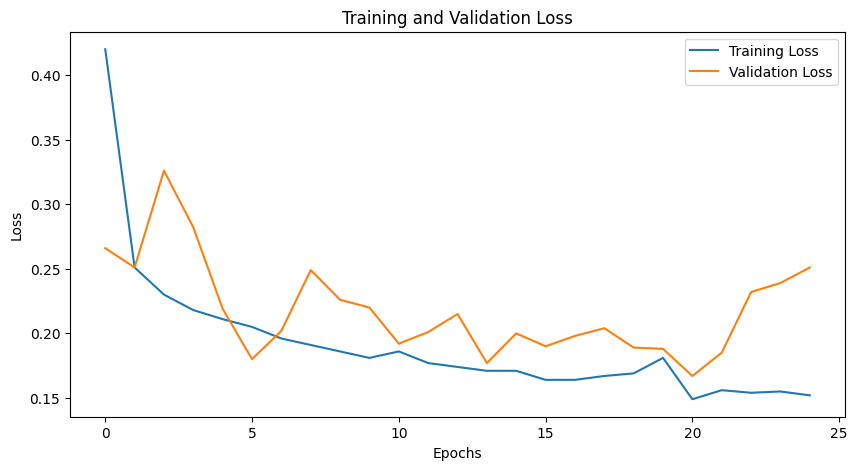

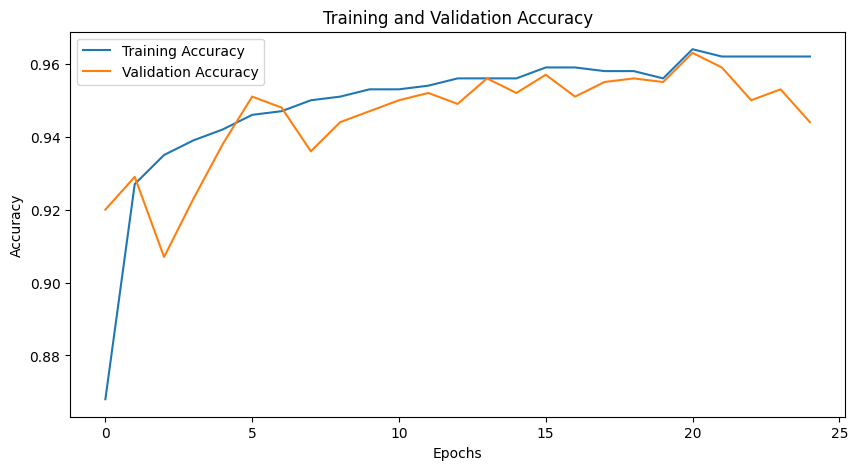

In [17]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [18]:
torch.save(model,'Trained_Digit_classification.pt') #saving the model for future usage

### Testing

#### Functions:
1. **`get_sliced_sudoku_images(sudoku_image)`**:
   - Slices the given Sudoku image into smaller grids of size 28x28 pixels.

2. **`get_index_value(index)`**:
   - Converts the given index to a string representing row and column values.

3. **`predict_digits(index, images)`**:
   - Predicts the digits in each grid image of the Sudoku puzzle.
   - Returns lists containing the IDs and predicted values for each grid image.

In [30]:
def get_sliced_sudoku_images(sudoku_image):

    sliced_image_size = 28
    sliced_images = []
    height, width = sudoku_image.shape[:2] # value 252
    for rows in range(0, height, sliced_image_size):
        for columns in range(0, width, sliced_image_size):
            # [0:28, 0:28] ,[0:28, 28:56],...[0:28, 224:252],[28:56, 0:28],......,[224:252, 224:252]
            sub_image = sudoku_image[rows:rows+sliced_image_size, columns:columns+sliced_image_size] 
            sliced_images.append(sub_image)

    return sliced_images

In [31]:
def get_index_value(index) : 
    row = index // 9
    column = index % 9
    return str(row)+str(column)

### Processing Test Images:
- Loads the test images from the file path specified.
- Iterates over each test image:
  - Slices the Sudoku image into grid images.
  - Predicts the digits in each grid image using the trained model.
  - Combines the IDs and predicted values into a DataFrame.
  - Appends the DataFrame to a list of results.

In [32]:
import torch
trained_model = torch.load('Trained_Digit_classification.pt')

def predict_digits(index,images):
    prediction_per_image_id = []
    prediction_per_image_values = []
    for img_index ,grid_image in enumerate(images) :
        tensored_image = torch.from_numpy(grid_image.flatten()).float().to(device)
        with torch.no_grad():
            is_zero = torch.all(tensored_image == 0).item()
        if is_zero:
            predicted_labels = 0
        else:
            trained_model.eval()
            #normalise the image
            normalized_image = (tensored_image / 255.0 - 0.5) / 0.5
            tensored_image = normalized_image.view(1,-1)
            predictions = trained_model(tensored_image)
            _, predicted_labels = torch.max(predictions, 1)
            predicted_labels = predicted_labels.item()
    
        row_column_values = get_index_value(img_index)
        per_image_id = str(index)+ '_' + row_column_values
        prediction_per_image_id.append(per_image_id)
        prediction_per_image_values.append(predicted_labels)
    return prediction_per_image_id, prediction_per_image_values

### Saving Predictions:
- Concatenates all the DataFrames containing predictions into one DataFrame.
- Saves the combined DataFrame as 'final_predictions-Task-1.csv' file in the specified.

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

test_images_path = r"/kaggle/input/sudoku-task1/test_images.npy"
results_combined = []
if os.path.exists(test_images_path):
    test_images = np.load(test_images_path, mmap_mode='r')
    for index,test_image in enumerate(test_images) : 
        sudoku_image_grid = get_sliced_sudoku_images(test_image)
        id,predicted_digits = predict_digits(index,sudoku_image_grid)
        results = pd.DataFrame({'id': id , 'values' : predicted_digits})
        results_combined.append(results)

    to_csv = pd.concat(results_combined)       
    to_csv.to_csv('final_predictions-Task-1.csv', index = False)      
else:
    print(f"Cannot find image path : {test_images_path}")